# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [ ]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [ ]:
import warnings #Used to ignore the warning given as output of the code.
warnings.filterwarnings('ignore')

import numpy as np # Basic libraries of python for numeric and dataframe computations.
import pandas as pd

import matplotlib.pyplot as plt #Basic library for data visualization.
import seaborn as sns #Slightly advanced library for data visualization

from sklearn.metrics.pairwise import cosine_similarity #To compute the cosine similarity between two vectors.
from collections import defaultdict #A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error # A performance metrics in sklearn.

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
# Loading the dataset
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Python Course/Week Seven RS/project/ratings_Electronics.csv")

In [ ]:
data.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   AKM1MP6P0OYPR  object 
 1   0132793040     object 
 2   5.0            float64
 3   1365811200     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


**Add column names ['user_id', 'prod_id', 'rating', 'timestamp']**

In [ ]:
#Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
data.rename(columns = {'AKM1MP6P0OYPR':'user_id',
                     '0132793040': 'prod_id',
                     '5.0':'rating',
                     '1365811200':'timestamp'}, inplace = True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    object 
 1   prod_id    object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


**Drop the column timestamp**

In [ ]:
# Dropping the "timestamp" column
data.drop("timestamp", axis = 1, inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


**Copy the data to another DataFrame called df**

In [ ]:
df = data.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


**As this dataset is very large and has 7,824,481 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

**Remove users who rated less than 50 times**

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
df.groupby('user_id')['rating'].count()

user_id
A100UD67AHFODS    116
A100WO06OQR8BQ    132
A105S56ODHGJEK     68
A105TOJ6LTVMBG     71
A10AFVU66A79Y1     65
                 ... 
AZBXKUH4AIW3X      53
AZCE11PSTCH1L      60
AZMY6E8B52L2T     189
AZNUHQSHZHSUE      54
AZOK5STV85FBJ      54
Name: rating, Length: 1540, dtype: int64

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

**Remove products which are rated less than 5 times**

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_prods = []

for prod, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_prods.append(prod)

df_final = df.loc[~ df.prod_id.isin(remove_prods)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


In [ ]:
df_final.groupby('prod_id')['rating'].count()

prod_id
1400501466     6
1400532655     6
1400599997     5
9983891212     8
B00000DM9W     5
              ..
B00L21HC7A    16
B00L2442H0    12
B00L26YDA4    13
B00L3YHF6O    14
B00LGQ6HL8     5
Name: rating, Length: 5689, dtype: int64

In [ ]:
df_final.groupby('user_id')['rating'].count()

user_id
A100UD67AHFODS     53
A100WO06OQR8BQ     77
A105S56ODHGJEK     58
A105TOJ6LTVMBG     32
A10AFVU66A79Y1     47
                 ... 
AZBXKUH4AIW3X      22
AZCE11PSTCH1L      23
AZMY6E8B52L2T     105
AZNUHQSHZHSUE      30
AZOK5STV85FBJ      14
Name: rating, Length: 1540, dtype: int64

## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)

**Observations:**
- There are 65290 rows and 3 coloumns


### **Data types**

In [ ]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Observations**
- user_id and prod_id are objects and rating if float data type



### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df_final.isnull().value_counts()

user_id  prod_id  rating
False    False    False     65290
Name: count, dtype: int64

**observations here**


*   No missing values



### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe()

,rating
count,65290.000000
mean,4.294808
std,0.988915
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [ ]:
df_final.rating.value_counts(normalize=True)

rating
5.0    0.556211
4.0    0.277638
3.0    0.099265
2.0    0.038520
1.0    0.028366
Name: proportion, dtype: float64

**Observations**
- Majority, over 55% of the ratings are 5.
- This shows it is skewed to the left, with majority of the datapoints btween 4 anf 5 ratings

### **Checking the rating distribution**

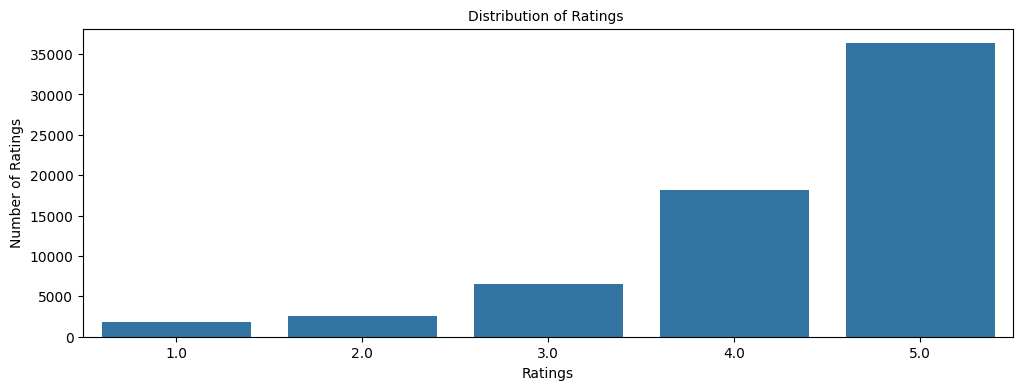

In [ ]:
# Create the plot and provide observations
# Distribution of ratings
plt.figure(figsize = (12, 4))
sns.countplot(x="rating", data=df_final)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()


**Observations**
- We can see ratings are skewed to the left, meaning most of the products are rated 5.0, More than 70% of the users gave ratings 4.0 and 5.0
- More than half, 55% of the ratings are 5.0, Followed by 4.0 which is 28%. Which we can say majority of the products are very much liked by the users.
- Very few users give rating 1.0 and 2.04


### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
df_final['user_id'].nunique()


1540

In [ ]:
# Finding the number of unique products
df_final['prod_id'].nunique()

5689

**Observations**
- There are 1540 users
- There are 5689 products in the dataset.
- As per the number of unique users and products, there is a **possibility of 1540 * 5689 = 8,761,060 ratings** in the dataset. But **we only have 65290 ratings**, i.e., not every user has interacted with every product in the dataset. So, we can build a recommendation system to recommend products to users which they have not interacted with.

In [ ]:
df_final.groupby(['user_id', 'prod_id']).count()

rating
user_id        prod_id           
A100UD67AHFODS B00004Z5M1       1
               B0001D3K8A       1
               B000233WJ6       1
               B0002KVQBA       1
               B0002SQ2P2       1
...                           ...
AZOK5STV85FBJ  B005PQTYHE       1
               B006MPRFJQ       1
               B00AANMVNQ       1
               B00B25P27S       1
               B00FB2XNCE       1

[65290 rows x 1 columns]

In [ ]:
df_final.groupby(['user_id', 'prod_id']).count()['rating'].sum()

65290

**Observation:**
- The **sum is equal to the total number of observations**, which implies that **there is only one interaction** per "user and product" pair.

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
df_final['user_id'].value_counts().sort_values(ascending=False).head(10)

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: count, dtype: int64

**Observations**

- The user: ADLVFFE4VBT8 has interacted with/rated majority of the products 295
- And all the above 10 users have interacted with about 2000 of the products
- We have 5689 products. So, in case of the first user with 295 interactions we have 5689 - 295 = 5394 products that we can still reccomend this user
- We can build a recommendation system to predict which other products we can reccomend to this user

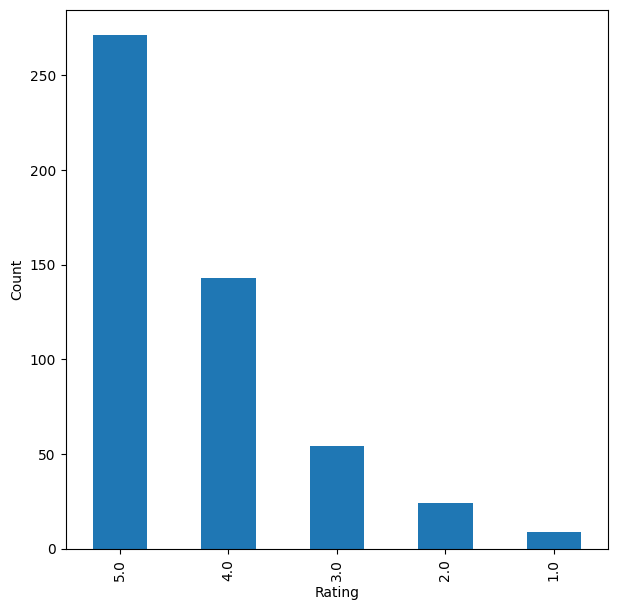

In [ ]:
# Plotting distributions of ratings for the user who has interacted the most

plt.figure(figsize=(7,7))

df[df['user_id'] == 'ADLVFFE4VBT8']['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')
plt.show()

**Observations:**
- We can see that this user has rated majority of the products as 5. Followed by 4.
- It could be that this user is an Amazon influencer who buys and  rates the products and make money.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**
**Here we find the most popular products based on the raking**

In [ ]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()
# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})


In [ ]:
# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by=['avg_rating'], ascending=False)


In [ ]:
# See the first five records of the "final_rating" dataset
final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(data, n, min_interaction = 100):

    # Finding restautants with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)

    return recommendations.index[:n]


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
print('top 5 products with 50 minimum interactions based on popularity:\n', list(top_n_products(final_rating, 5, 50)))

top 5 products with 50 minimum interactions based on popularity:
 ['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
print('top 5 products with 100 minimum interactions based on popularity:\n',list(top_n_products(final_rating, 5, 100)))

top 5 products with 100 minimum interactions based on popularity:
 ['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Observations for base line user-user Similarity-based model**
- We have calculated **RMSE** to check **how far the overall predicted ratings** are from the **actual ratings**, which here for our base line model is 1.0012
- Intuition of Recall - We are getting a **recall of almost 0.858**, which means out of **all the relevant products, 85.8% are recommended**.
- Intuition of Precision - We are getting a **precision of almost 0.855**, which means **out of all the recommended products 85.5% are relevant**.
- Here **F_1 score** of the **baseline model is almost 0.856**. It indicates that **mostly recommended products were relevant and relevant products were recommended** to the user. This is a good performance for a base line model. We will try to even improve this, later by using **GridSearchCV by tuning different hyperparameters** of this algorithm.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

**Observations**
- The above output shows that **the actual rating for this user-item pair is 5 and the predicted rating is 3.40** by the **user-user-similarity-based baseline model**. This implies that the model is under-estimating the ratings.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
userL = df_final[df_final['prod_id'] != '1400501466']
userL

,user_id,prod_id,rating
2081,A2ZR3YTMEEIIZ4,1400532655,5.0
2149,A3CLWR1UUZT6TG,1400532655,5.0
2161,A5JLAU2ARJ0BO,1400532655,1.0
2227,A1P4XD7IORSEFN,1400532655,4.0
2362,A341HCMGNZCBIT,1400532655,5.0
...,...,...,...
7824422,A34BZM6S9L7QI4,B00LGQ6HL8,5.0
7824423,A1G650TTTHEAL5,B00LGQ6HL8,5.0
7824424,A25C2M3QF9G7OQ,B00LGQ6HL8,5.0
7824425,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations**
- As we can see the estimated rating for this user-item pair is 4.29  based on this similarity based baseline model.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9710851135874058
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': True}}


**Observations**
- The above are the optimal values given for each of the hypermarameters. We will use these values to build our final optimized model for user-user Similarity-based model

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9530
Precision:  0.847
Recall:  0.893
F_1 score:  0.869


**Observations**
- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model increased little bit (0.869) when compared to the baseline model(0.856), but the error dropped from 1.0012 to 0.9530 which is a good improvement**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations**
- The above output shows that after hypertuning the patameters **the actual rating for this user-item pair is 5 and the predicted rating is 4.29**, which is closer to 5 compared to the base model prediction of 3.4. This implies that hypertuning the parameters improved the performance

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
# Predicting rating for a sample user with a non interacted product
sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations**
- As we can see the estimated rating for this user-item pair is 4.29 which is similar to the prediction from similarity based baseline model.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
print("Similar users to a given user (nearest neighbors):")
sim_user_user_optimized.get_neighbors(0, 5)

Similar users to a given user (nearest neighbors):


[6, 42, 44, 54, 66]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
print('5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system')
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system


,prod_id,predicted_ratings
0,1400599997,5
1,B00000DM9W,5
2,B00000K4KH,5
3,B00001W0DI,5
4,B00002EQCW,5


### **Correcting the Ratings and Ranking the above products/ businesses**

While comparing the ratings of two products, it is not only the **ratings** that describe the **likelihood of the user to that product**. Along with the rating the **number of users who have seen that product** also becomes important to consider. Due to this, we have calculated the **"corrected_ratings"** for each product. Commonly higher the **"rating_count" of a product more it is liked by users**. To interpret the above concept, a **product rated 4 by 3 people is less liked in comparison to a product rated 3 by 50 people**. It has been **empirically found that the likelihood of the product is directly proportional to the inverse of the square root of the rating_count of the product**.

In [ ]:
def ranking_products(recommendations, final_rating):
    # Sort the products based on ratings count
    ranked_products = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending = False)[['rating_count']].reset_index()

    # Merge with the recommended businesses to get predicted ratings
    ranked_products = ranked_products.merge(pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings']), on = 'prod_id', how = 'inner')

    # Rank the businesses based on corrected ratings
    ranked_products['corrected_ratings'] = ranked_products['predicted_ratings'] - 1 / np.sqrt(ranked_products['rating_count'])

    # Sort the businesses based on corrected ratings
    ranked_products = ranked_products.sort_values('corrected_ratings', ascending = False)

    return ranked_products

**Note:** In the **above-corrected rating formula**, we can add the **quantity `1 / np.sqrt(n)` instead of subtracting it to get more optimistic predictions**. But here we are **subtracting this quantity**, as there are some products with ratings 5 and **we can't have a rating more than 5 for a product**.

In [ ]:
# Applying the ranking products function and sorting it based on corrected ratings
print('Corrected prediction of top 5 products for userId = "A3LDPF5FMB782Z"')
ranking_products(recommendations, final_rating)

Corrected prediction of top 5 products for userId = "A3LDPF5FMB782Z"


,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B00001W0DI,8,5,4.646447
1,B00002EQCW,8,5,4.646447
2,1400599997,5,5,4.552786
3,B00000DM9W,5,5,4.552786
4,B00000K4KH,5,5,4.552786


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)
# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841



**Observations for base line item-item Similarity-based model**
- We have calculated **RMSE** to check **how far the overall predicted ratings** are from the **actual ratings**, which here for our base line model RMSE at 0.9950
- Intuition of Recall - We are getting a **recall of 0.845**, which means out of **all the relevant products, 84.5% are recommended**.
- Intuition of Precision - We are getting a **precision of 0.838**, which means **out of all the recommended products 83.8% are relevant**.
- Here **F_1 score** of the **baseline model is almost 0.841**. It indicates that **mostly recommended products were relevant and relevant products were recommended** to the user. This is a good performance for a base line model. We will try to even improve this, later by using **GridSearchCV by tuning different hyperparameters** of this algorithm.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

**Write your observations here:**


* We see that the base model predicted the rating as 4.27 while the actual rating 5.00. This is not bad for a base model. Let's see if we can improve this later with hyper-parameter tuning



Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations**
- As we can see the estimated rating for this user-item pair is 4.29  based on this item-item similarity based baseline model.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }
# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fitting the data
gs.fit(data)
# Find the best RMSE score
print(gs.best_score['rmse'])
# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9749514703139366
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


**Observations**
- The above are the optimal values given for each of the hypermarameters. We will use these values to build our final optimized model for item-item Similarity-based model

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 20, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9578
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


**Observations**
- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model is better than the baseline model(0.841)**. There is a good drop in the RMSE value to 0.95(base model 0.99) after tuning the hyperparameters. Hence the tuned model is doing better than the earlier one.


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.71   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.7105263157894735, details={'actual_k': 20, 'was_impossible': False})

**Observations**
- The above output shows that after hypertuning the patameters **the actual rating for this user-item pair is 5 and the predicted rating is 4.71**, which is closer to 5 compared to the base model prediction of 4.27. This implies that hypertuning the parameters improved the performance

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**
- As we can see the estimated rating for this user-item pair after hypertuning the parameters is 4.29  which is same as the baseline model.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
#Identifying similar items to the item with internal id 0 (nearest neighbors)
print("Similar items to a given item (nearest neighbors):")
sim_item_item_optimized.get_neighbors(0, k = 5)

Similar items to a given item (nearest neighbors):


[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
print('5 products for userId = "A1A5KUIIIHFF4U" with item-item similarity based recommendation system')
pd.DataFrame(recommendations, columns = ['product_id', 'predicted_ratings'])

5 products for userId = "A1A5KUIIIHFF4U" with item-item similarity based recommendation system


,product_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


In [ ]:
# Applying the ranking_products function and sorting it based on corrected ratings
print('Corrected prediction of top 5 products for userId = "A1A5KUIIIHFF4U"')
ranking_products(recommendations, final_rating)

Corrected prediction of top 5 products for userId = "A1A5KUIIIHFF4U"


,prod_id,rating_count,predicted_ratings,corrected_ratings
0,9983891212,8,4.292024,3.938471
1,B00000J1V5,7,4.292024,3.914060
2,1400532655,6,4.292024,3.883776
3,1400599997,5,4.292024,3.844810
4,B00000DM9W,5,4.292024,3.844810


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state = 1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866



**Observations for base line Model-Based Collaborative Filtering - Matrix Factorization**
- We have calculated **RMSE** to check **how far the overall predicted ratings** are from the **actual ratings**, which here for our base line model RMSE at 0.8882
- Intuition of Recall - We are getting a **recall of 0.88**, which means out of **all the relevant products, 88% are recommended**.
- Intuition of Precision - We are getting a **precision of 0.853**, which means **out of all the recommended products 85.3% are relevant**.
- Here **F_1 score** of this **baseline model is almost 0.867**. It indicates that **mostly recommended products were relevant and relevant products were recommended** to the user. This is a good performance for a base line model. We will try to even improve this, later by using **GridSearchCV by tuning different hyperparameters** of this algorithm.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

**Observations**
- As we can see - **the actual rating** for this user-item pair is 5 and the predicted rating is 4.08. The base model is under-estimating the rating. We will try to fix this later by **tuning the hyperparameters** of the model using GridSearchCV.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

**Observations**
- We can see that the **estimated rating** for this **user-item pair** is 4.40. based on this **matrix factorization based baseline model**.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}
# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fitting data
gs.fit(data)
# Best RMSE score
print(gs.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.896570430446553
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


**Observations**
- The above are the optimal values given for each of the hypermarameters. We will use these values to build our final optimized model for Matrix Factorization.

Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.2, random_state = 1)
# Train the algorithm on the trainset
svd_optimized = svd_optimized.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


**Observations**
- As we can see there is not much difference in the tuned and the base models Base model RMSE(0.8882) and F1 score(0.866).

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.13   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.128589011282042, details={'was_impossible': False})

**Observations**
- The tuned model predicted est rating to be 4.13 which is a improvemnt from est = 4.08  from the base model

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.22   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.216280997100113, details={'was_impossible': False})

**Observations**
- We can see that the **estimated rating** for this **user-item pair** is
 with optimization 4.22. The base model predicted it to be 4.40.

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with ptimized Matric Factorization based recommendation system.**

In [ ]:
# Getting top 5 recommendations for user_id A1A5KUIIIHFF4Uusing "svd_optimized" algorithm
svd_recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, svd_optimized)

In [ ]:
print('5 reccomended products for userId = "A1A5KUIIIHFF4U" with matrix Factorized optimized recommendation system')
pd.DataFrame(svd_recommendations, columns = ['prod_id', 'predicted_ratings'])

5 reccomended products for userId = "A1A5KUIIIHFF4U" with matrix Factorized optimized recommendation system


,prod_id,predicted_ratings
0,B00AR95ESC,4.200191
1,B000JV9LUK,4.198581
2,B002M3SOCE,4.182910
3,B000PEF254,4.181580
4,B00HG1L334,4.172999


In [ ]:
# Applying the ranking_products function and sorting it based on corrected ratings
print('Corrected prediction of top 5 products for userId = "A1A5KUIIIHFF4U"')
ranking_products(recommendations, final_rating)


Corrected prediction of top 5 products for userId = "A1A5KUIIIHFF4U"


,prod_id,rating_count,predicted_ratings,corrected_ratings
0,9983891212,8,4.292024,3.938471
1,B00000J1V5,7,4.292024,3.914060
2,1400532655,6,4.292024,3.883776
3,1400599997,5,4.292024,3.844810
4,B00000DM9W,5,4.292024,3.844810


### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**
In this case study, we built recommendation systems using 4 different algorithms. They are as follows:
- Rank-based using averages
- User-user-similarity-based collaborative filtering
- Item-item-similarity-based collaborative filtering
- model-based (matrix factorization) collaborative filtering

- Optimizing with hypertuning parameters, improved the performance for similarity based collaborative models but not much for matrix factorization

- Overall, the **matrix factorization** has given the **best performance** in terms of both RMSE(0.88), but the F1score is pretty much same accross all the 3 models around 0.86

- Matrix Factorization has lower RMSE (0.88) due to the reason that it assumes that both prods and users are present in some low dimensional space describing their properties and recommend a products based on its proximity to the user in the latent space. Implying it accounts for latent factors as well.

- While predicting an estimated rating for a particular user-item pair item-item-similarity-based collaborative filtering did a good job at predicting closer values to the actual, compared to the other to models. Actual is 5 and it predicted it to be 4.71

- While predicting a rating for a user-item pair where the user did not have an interaction with the item before, both similarty based models had the same value 4.29, while matrix factorization predicted it to be 4.40

- To demonstrate **"user-user-similarity-based collaborative filtering","item-item-similarity-based collaborative filtering", and "model-based (matrix factorization) collaborative filtering"**, **surprise** library has been introduced. For these algorithms **grid search cross-validation is applied to find the best working model**, and using that the **corresponding predictions are done**.

- **For performance evaluation** of these models **precision@k and recall@k** are introduced in this case study. Using these two metrics **F_1 score** is calculated for each working model.

